In [196]:
from typing import Tuple
import pandas as pd
from tqdm import tqdm
import os
import time
import random
import numpy as np
from os.path import isfile, join
from pydub import AudioSegment
from scipy.io import wavfile

import torch
from torch import nn
from torchaudio import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Constants

In [46]:
RATE = 44100
MEL_SPECTROGRAM_BUCKETS = 128
MEL_SPECTROGRAM_WINDOW_LENGTH = 224
SPECTROS_PER_SECOND = RATE // (MEL_SPECTROGRAM_WINDOW_LENGTH / 2) - 1
CHUNKS_PER_SECOND = 2
CHUNK_SIZE_IN_SPECTROS = int(SPECTROS_PER_SECOND // CHUNKS_PER_SECOND)

TRAINSET_RATIO = 0.75

# LSTM basic

In [ ]:
batch_size = 64
seq_length = 10
num_directions = 1  # If the LSTM is bidirectional, num_directions should be 2, else it should be 1.
num_layers = 1

input_size = 10
hidden_size = 20  # Hidden size is number of features of the hidden state for RNN.

In [ ]:
rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
input = torch.randn(batch_size, seq_length, input_size)
h0 = torch.randn(num_directions*num_layers, batch_size, hidden_size)
c0 = torch.randn(num_directions*num_layers, batch_size, hidden_size)
output, (hn, cn) = rnn(input, (h0, c0))

print(f'output: {output.size()}')
print(f'hn: {hn.size()}')
print(f'cn: {cn.size()}')

<hr>

# Dataset

In [3]:
AUDIO_FOLDER = "C:\\Users\\amity\\PycharmProjects\\aimpathy\\data\\PMEmo\\PMEmo2019\\chorus"
THAYER_ANOTATIONS_CSV = "C:\\Users\\amity\\PycharmProjects\\aimpathy\\data\\PMEmo\\PMEmo2019\\annotations\\dynamic_annotations.csv"
thayer_annotations_df = pd.read_csv(THAYER_ANOTATIONS_CSV)

In [4]:
audio_files = [f for f in os.listdir(AUDIO_FOLDER) if isfile(join(AUDIO_FOLDER, f))]
audio_data = dict()
torch_spectorgrams = dict()
spectorgrammer = transforms.MelSpectrogram(sample_rate=RATE, n_fft=(MEL_SPECTROGRAM_BUCKETS * 2 - 2), win_length=MEL_SPECTROGRAM_WINDOW_LENGTH, power=2, normalized=True)

C:\Users\amity\Anaconda3\envs\aimpathy\lib\site-packages\torchaudio\functional\functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (128) may be set too low.
  warnings.warn(


In [6]:
spectrograms = dict()
for audio_file in tqdm(audio_files, total=len(audio_files)):
    sound = AudioSegment.from_mp3(os.sep.join([AUDIO_FOLDER, audio_file])).set_channels(1)
    audio_file_wave = sound.export(format="wav", bitrate=RATE)
    sample_rate, samples = wavfile.read(audio_file_wave)
    spectogram = spectorgrammer(torch.from_numpy(samples/(2**15)).float().reshape((1, -1)))
    spectrograms[audio_file] = spectogram
    audio_file_wave.close()
spectrograms = {key: value for key, value in spectrograms.items() if ".wav" not in key}

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [03:11<00:00,  4.15it/s]


In [195]:
dataset = list()  # spectrogram, (valence, arousal)
for file_name, spectrogram in tqdm(spectrograms.items(), total=len(spectrograms)):
    music_id = int(file_name.replace(".mp3", ""))
    max_frame_time = thayer_annotations_df[thayer_annotations_df["musicId"] == music_id]["frameTime"].max()
    if np.isnan(max_frame_time):
        # print(f"Skipping {music_id}")
        continue
    for i in range(int(CHUNKS_PER_SECOND * max_frame_time)):
        data_df = thayer_annotations_df[(thayer_annotations_df["musicId"] == music_id) & (thayer_annotations_df["frameTime"] == i/2)]
        if data_df.empty:
            #  print(f"Skipping {musicI_id} - {i/2}")
            continue
        valence = data_df.iloc[0]["Valence(mean)"]
        arousal = data_df.iloc[0]["Arousal(mean)"]
        dataset.append((spectrogram[0, :, int((i/2-1)*CHUNK_SIZE_IN_SPECTROS): int((i/2)*CHUNK_SIZE_IN_SPECTROS)], (valence*2-1, arousal*2-1)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 793/793 [01:48<00:00,  7.30it/s]


In [182]:
min([row[0].shape for row in dataset]), max([row[0].shape for row in dataset])

(torch.Size([128, 196]), torch.Size([128, 196]))

In [183]:
random.shuffle(dataset)
trainset = [datum for datum in dataset[:int(TRAINSET_RATIO*len(dataset))]]
testset = [datum for datum in dataset[int(TRAINSET_RATIO*len(dataset)):]]

### Plot spectrogram

In [35]:
import matplotlib.pyplot as plt
import librosa

In [36]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None, ymax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    if ymax:
        axs.set_ylim((0, ymax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

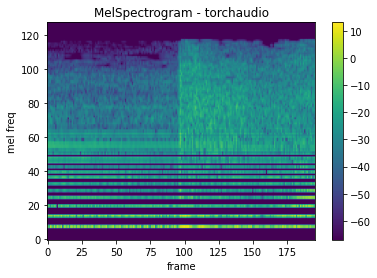

In [41]:
plot_spectrogram(dataset[1000][0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

# AudioLSTMCNN

In [336]:
class AudioLSTMCNN(nn.Module):      
    def __init__(self, input_shape: Tuple[int, int], out_size: int = 2, cnn_channels: int = 64):
        """
        :param input_shape: (X, Y). For a spectogram with 128 buckets and chunk size of 196, will be (128, 196)
        """
        # call the parent constructor
        super(AudioLSTMCNN, self).__init__()
        
        self.conv11 = nn.Conv2d(in_channels=1, out_channels=cnn_channels, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.relu11 = nn.ReLU()
        self.conv12 = nn.Conv2d(in_channels=cnn_channels, out_channels=cnn_channels, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.relu12 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.conv21 = nn.Conv2d(in_channels=cnn_channels, out_channels=cnn_channels, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.relu21 = nn.ReLU()
        self.conv22 = nn.Conv2d(in_channels=cnn_channels, out_channels=cnn_channels, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.relu22 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.conv3 = nn.Conv2d(in_channels=cnn_channels, out_channels=cnn_channels * 2, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=(3, 3))
        self.dropout3 = nn.Dropout(p=0.25)
        
        self.conv4 = nn.Conv2d(in_channels=cnn_channels * 2, out_channels=cnn_channels * 4, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=(3, 3), stride=(3, 3))
        self.dropout4 = nn.Dropout(p=0.25)
        
        self.conv5 = nn.Conv2d(in_channels=cnn_channels * 4, out_channels=cnn_channels * 4, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.relu5 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(kernel_size=(3, 3), stride=(3, 3))
        self.dropout5 = nn.Dropout(p=0.25)
        
        self.lstm6 = nn.LSTM(cnn_channels * 4, cnn_channels * 4, batch_first=True)
        self.hidden = (torch.zeros(1, 1 , cnn_channels * 4),
                       torch.zeros(1, 1 , cnn_channels * 4))
        self.fc6 = nn.Linear(in_features=cnn_channels * 4, out_features=cnn_channels * 4)
        self.dropout6 = nn.Dropout(p=0.5)
        
        self.fc7 = nn.Linear(in_features=cnn_channels * 4, out_features=cnn_channels * 4)
        self.dropout7 = nn.Dropout(p=0.5)
        
        self.fc8 = nn.Linear(in_features=cnn_channels * 4, out_features=2)
        self.final = nn.Tanh()
  
        
    def forward(self, x):
        x = x.reshape((1, 1, x.shape[0], -1))
        
        x = self.conv11(x)
        x = self.relu11(x)
        x = self.conv12(x)
        x = self.relu12(x)
        x = self.maxpool1(x)
        
        x = self.conv21(x)
        x = self.relu21(x)
        x = self.conv22(x)
        x = self.relu22(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)
        
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x)
        
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)
        x = self.dropout5(x)
        
        x = x.view(x.size(0), x.size(1), -1)
        x = x.permute(0, 2, 1)   
        
        x, self.hidden = self.lstm6(x, self.hidden)
        x = self.fc6(x)
        x = self.dropout6(x)
        
        x = self.fc7(x)
        x = self.dropout7(x)
        
        x = self.fc8(x)
        
        final_x = self.final(x.reshape((-1)))
        final_x = final_x*2 - 1
        
        return final_x


In [337]:
model = AudioLSTMCNN(input_shape=(128, 196), out_size=2)
model_c = model.cuda()

In [338]:
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(model_c.parameters(), lr=0.0005)

In [339]:
print(dataset[0][0].shape)
print(dataset[0][0].reshape((1, 1, MEL_SPECTROGRAM_BUCKETS, -1)).shape)

torch.Size([128, 196])
torch.Size([1, 1, 128, 196])


In [ ]:
start_time = time.time()
EPOCS = 100
PRINT_MARK = 500
BATCH_SIZE = 1001
STOP_LOSS = 0.01


for epoc in range(EPOCS):
    losses = list()
    train_sample = random.sample(trainset, BATCH_SIZE)
    for batch_i, (X_train, (valence, arousal)) in enumerate(train_sample):
        optimizer.zero_grad()
        model.hidden = (torch.zeros(model.hidden[0].shape).cuda(),
                        torch.zeros(model.hidden[0].shape).cuda())
        
        y_train = torch.Tensor((valence, arousal)).cuda()
        # Apply the model
        y_pred = model(X_train.cuda())  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)

        # Update parameters
        loss.backward(retain_graph=True)
        optimizer.step()

        losses.append(loss.cpu().item())
        
        # Print interim results
        if batch_i > 0 and batch_i%PRINT_MARK == 0:
            print(f'{epoc:2}-{batch_i:4} | loss: {loss.item():.5f}[{np.mean(losses):.5f}]  [{abs(y_train[0] - y_pred[0]):.5f}, {abs(y_train[1] - y_pred[1]):.5f}]')
            if np.mean(losses) < STOP_LOSS:
                break

    if np.mean(losses) < STOP_LOSS:
        break
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

 0- 500 | loss: 0.44808[0.15898]  [0.71208, 0.62379]
 0-1000 | loss: 0.00429[0.15024]  [0.01639, 0.09120]
 1- 500 | loss: 0.12248[0.14068]  [0.28392, 0.40540]
 1-1000 | loss: 0.38468[0.14203]  [0.83565, 0.26658]
 2- 500 | loss: 0.03934[0.13593]  [0.02590, 0.27931]
 2-1000 | loss: 0.85922[0.14108]  [0.54851, 1.19062]
 3- 500 | loss: 0.40041[0.13497]  [0.70479, 0.55145]
 3-1000 | loss: 0.05098[0.14149]  [0.04990, 0.31539]
 4- 500 | loss: 0.02826[0.13940]  [0.22079, 0.08815]
 4-1000 | loss: 0.05310[0.14167]  [0.31051, 0.09886]
 5- 500 | loss: 0.08229[0.13098]  [0.04878, 0.40275]
 5-1000 | loss: 0.14729[0.13345]  [0.53459, 0.09374]
 6- 500 | loss: 0.00638[0.12896]  [0.01253, 0.11223]
 6-1000 | loss: 0.00446[0.13640]  [0.08927, 0.03081]
 7- 500 | loss: 0.04750[0.13373]  [0.09767, 0.29233]
 7-1000 | loss: 0.38526[0.13939]  [0.63255, 0.60860]
 8- 500 | loss: 0.03783[0.13679]  [0.18061, 0.20745]
 8-1000 | loss: 0.16314[0.12960]  [0.44817, 0.35416]
 9- 500 | loss: 0.17557[0.13807]  [0.12161, 0.

## Test model

In [333]:
losses = list()

with torch.no_grad():
    for batch_i, (X_test, (valence, arousal)) in tqdm(enumerate(testset), total=len(testset)):
        y_test = torch.Tensor((valence, arousal)).cuda()
        # Apply the model
        y_val = model(X_test.cuda())
        loss = criterion(y_val, y_test)
        losses.append(loss.cpu())

100%|███████████████████████████████████████████████████████████████████████████████████████████| 8909/8909 [00:32<00:00, 271.79it/s]


In [335]:
print(f"Mean: {np.mean(losses):.5f}, median: {np.median(losses):.5f}")

Mean: 0.19716, median: 0.11532


In [324]:
test_index = 12
print(model_c(testset[0][0].cuda()))
print(testset[0][1])

tensor([-0.1054, -0.0105], device='cuda:0', grad_fn=<SubBackward0>)
(-0.14022500000000016, -0.37467499999999976)


In [264]:
criterion(model_c(testset[0][0].cuda()), torch.Tensor(testset[0][1]).cuda())

tensor(0.3962, device='cuda:0', grad_fn=<MseLossBackward0>)

In [308]:
model_c(testset[0][0].cuda())*2 - 1

tensor([-0.5271, -0.5102], device='cuda:0', grad_fn=<SubBackward0>)